In [1]:
import numpy as np
import torch


import json
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch import nn

from statistics import mean

In [2]:
import utils_generic as generic
import rrnn_modelo as rrnn

import train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


# Datos ConvAI2

In [4]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [5]:
convai_train = data['train']
convai_val = data['validation']


word_to_index = generic.create_word_to_index(convai_train)

convai_train_token = generic.tokenize_dataset_rrnn(convai_train,['about','to','as'],word_to_index) 
convai_val_token = generic.tokenize_dataset_rrnn(convai_val,['about','to','as'],word_to_index) 

In [6]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = rrnn.DatasetSingleTaskRRNN(convai_train_token,task,eval=False)

In [7]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = rrnn.DatasetSingleTaskRRNN(convai_val_token,task,eval=False)

# Datos md_gender

In [8]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [9]:
md_tokenized = generic.tokenize_dataset_rrnn(md_data,['about','to','as'],word_to_index) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = rrnn.DatasetSingleTaskRRNN(md_tokenized,task,eval=True)

# Creación dataloaders

In [10]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn)

In [11]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn)

In [12]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=rrnn.collate_fn)

# Prueba hiperparámetros 1

In [13]:
emb_dim = 20
vocab_size = len(word_to_index)
# num_labels = 2
lstm_hidden_dim = 128

## ABOUT

In [14]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6807883055783315 	 Validation loss: 0.6812492305949583 	 
  1%|          | 574/57400 [00:03<04:15, 222.17it/s]
Epoch 2 	 Training loss: 0.6683089954304778 	 Validation loss: 0.6651593052734763 	 
  2%|▏         | 1148/57400 [00:05<04:10, 224.58it/s]
Epoch 3 	 Training loss: 0.6574223327096747 	 Validation loss: 0.6564646737050202 	 
  3%|▎         | 1722/57400 [00:08<04:03, 228.22it/s]
Epoch 4 	 Training loss: 0.6487722595186599 	 Validation loss: 0.648879736156787 	 
  4%|▍         | 2296/57400 [00:11<04:07, 222.50it/s]
Epoch 5 	 Training loss: 0.6399999766607318 	 Validation loss: 0.6410138647435075 	 
  5%|▌         | 2870/57400 [00:14<04:05, 222.33it/s]
Epoch 6 	 Training loss: 0.631519454696868 	 Validation loss: 0.63351201101885 	 
  6%|▌         | 3444/57400 [00:17<04:09, 216.61it/s]
Epoch 7 	 Training loss: 0.6233231269524072 	 Validation loss: 0.6296175708205013 	 
  7%|▋         | 4018/57400 [00:19<04:03, 219.62it/s]
Epoch 8 	 Training loss: 0.61517

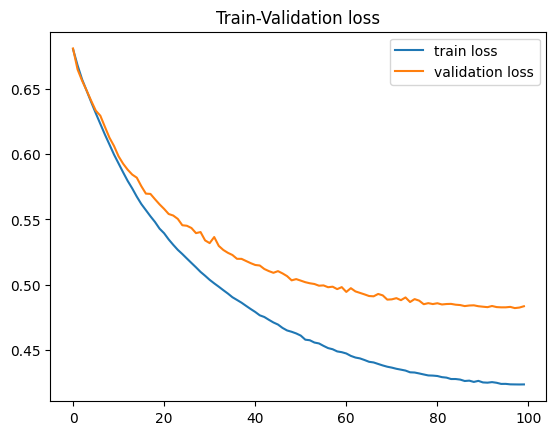

In [15]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_about_v1_1'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [16]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.6836734693877551, 'precision': 0.6836734693877551, 'f1': 0.6836734693877551, 'accuracy': 0.6836734693877551}
MALE {'recall': 0.7552083333333334, 'precision': 0.7552083333333334, 'f1': 0.7552083333333334, 'accuracy': 0.7552083333333334}
FEMALE {'recall': 0.615, 'precision': 0.615, 'f1': 0.615, 'accuracy': 0.615} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5138888888888888, 'precision': 0.5138888888888888, 'f1': 0.5138888888888888, 'accuracy': 0.5138888888888888}
MALE {'recall': 0.5766423357664233, 'precision': 0.5766423357664233, 'f1': 0.5766423357664233, 'accuracy': 0.5766423357664233}
FEMALE {'recall': 0.4461942257217848, 'precision': 0.4461942257217848, 'f1': 0.4461942257217848, 'accuracy': 0.4461942257217848} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5984354628422425, 'precision': 0.5984354628422425, 'f1': 0.5984354628422425, 'accuracy': 0.5984354628422425}
MALE {'recall': 0.62

In [17]:
# learning_rate = 5e-5
# optimizer = AdamW(model.parameters(), lr=learning_rate)

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6816483699693913 	 Validation loss: 0.6818774514279123 	 
  1%|          | 574/57400 [00:02<04:29, 211.15it/s]
Epoch 2 	 Training loss: 0.6727844401934421 	 Validation loss: 0.6660583908275023 	 
  2%|▏         | 1148/57400 [00:05<04:27, 210.40it/s]
Epoch 3 	 Training loss: 0.6629493193967002 	 Validation loss: 0.6580857866901463 	 
  3%|▎         | 1722/57400 [00:08<04:31, 204.75it/s]
Epoch 4 	 Training loss: 0.6546140482409075 	 Validation loss: 0.6482118297431428 	 
  4%|▍         | 2296/57400 [00:11<04:23, 208.95it/s]
Epoch 5 	 Training loss: 0.6464797084962864 	 Validation loss: 0.6404449666960764 	 
  5%|▌         | 2870/57400 [00:14<04:25, 205.19it/s]
Epoch 6 	 Training loss: 0.6370926596977154 	 Validation loss: 0.6303416692604453 	 
  6%|▌         | 3444/57400 [00:17<04:10, 215.73it/s]
Epoch 7 	 Training loss: 0.6278685585754674 	 Validation loss: 0.6230211197319677 	 
  7%|▋         | 4018/57400 [00:20<04:13, 210.59it/s]
Epoch 8 	 Training loss: 0.6

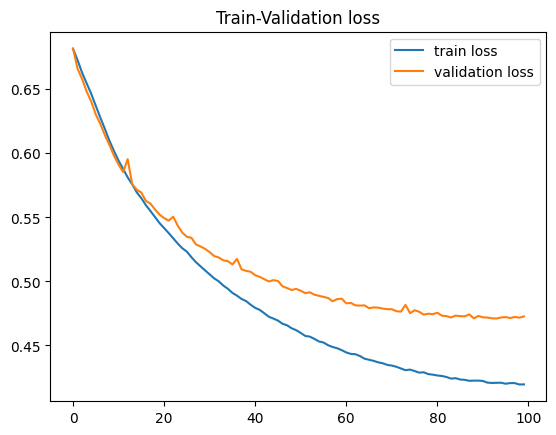

In [18]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_about_v1_2'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [19]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.6670918367346939, 'precision': 0.6670918367346939, 'f1': 0.6670918367346939, 'accuracy': 0.6670918367346939}
MALE {'recall': 0.8932291666666666, 'precision': 0.8932291666666666, 'f1': 0.8932291666666666, 'accuracy': 0.8932291666666666}
FEMALE {'recall': 0.45, 'precision': 0.45, 'f1': 0.45, 'accuracy': 0.45} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5378787878787878, 'precision': 0.5378787878787878, 'f1': 0.5378787878787878, 'accuracy': 0.5378787878787878}
MALE {'recall': 0.7737226277372263, 'precision': 0.7737226277372263, 'f1': 0.7737226277372263, 'accuracy': 0.7737226277372263}
FEMALE {'recall': 0.28346456692913385, 'precision': 0.28346456692913385, 'f1': 0.28346456692913385, 'accuracy': 0.28346456692913385} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5436766623207301, 'precision': 0.5436766623207301, 'f1': 0.5436766623207301, 'accuracy': 0.5436766623207301}
MALE {'recall': 0.79

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6805575720524538 	 Validation loss: 0.6834404236179287 	 
  1%|          | 574/57400 [00:02<04:24, 215.04it/s]
Epoch 2 	 Training loss: 0.6693535744105482 	 Validation loss: 0.6711569438546391 	 
  2%|▏         | 1148/57400 [00:05<04:24, 212.76it/s]
Epoch 3 	 Training loss: 0.6611818088679363 	 Validation loss: 0.6647004495232792 	 
  3%|▎         | 1722/57400 [00:08<04:23, 211.35it/s]
Epoch 4 	 Training loss: 0.6552750215920837 	 Validation loss: 0.6601277094776348 	 
  4%|▍         | 2296/57400 [00:11<04:17, 213.87it/s]
Epoch 5 	 Training loss: 0.649087562585957 	 Validation loss: 0.6537731896012516 	 
  5%|▌         | 2870/57400 [00:14<04:15, 213.11it/s]
Epoch 6 	 Training loss: 0.6425729654599566 	 Validation loss: 0.6458147208569414 	 
  6%|▌         | 3444/57400 [00:17<04:22, 205.60it/s]
Epoch 7 	 Training loss: 0.6351213369012294 	 Validation loss: 0.6379172650434203 	 
  7%|▋         | 4018/57400 [00:20<04:10, 213.09it/s]
Epoch 8 	 Training loss: 0.62

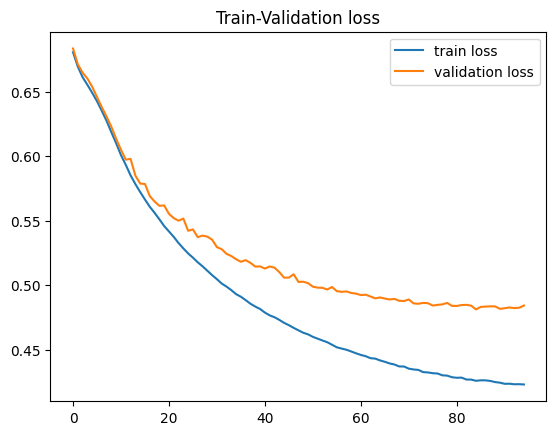

In [20]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_about_v1_3'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [21]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.6479591836734694, 'precision': 0.6479591836734694, 'f1': 0.6479591836734694, 'accuracy': 0.6479591836734694}
MALE {'recall': 0.3697916666666667, 'precision': 0.3697916666666667, 'f1': 0.3697916666666667, 'accuracy': 0.3697916666666667}
FEMALE {'recall': 0.915, 'precision': 0.915, 'f1': 0.915, 'accuracy': 0.915} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.48863636363636365, 'precision': 0.48863636363636365, 'f1': 0.48863636363636365, 'accuracy': 0.48863636363636365}
MALE {'recall': 0.18004866180048662, 'precision': 0.18004866180048662, 'f1': 0.18004866180048662, 'accuracy': 0.18004866180048662}
FEMALE {'recall': 0.821522309711286, 'precision': 0.821522309711286, 'f1': 0.821522309711286, 'accuracy': 0.821522309711286} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.559322033898305, 'precision': 0.559322033898305, 'f1': 0.559322033898305, 'accuracy': 0.559322033898305}
MALE {'recall': 0.25

In [22]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.6662414965986394, 'precision': 0.6662414965986394, 'f1': 0.6662414965986394, 'accuracy': 0.6662414965986394}
Métricas etiqueta male: {'recall': 0.6727430555555556, 'precision': 0.6727430555555556, 'f1': 0.6727430555555556, 'accuracy': 0.6727430555555556}
Métricas etiqueta female:  {'recall': 0.66, 'precision': 0.66, 'f1': 0.66, 'accuracy': 0.66}

 to
Resultado global: {'recall': 0.5134680134680134, 'precision': 0.5134680134680134, 'f1': 0.5134680134680134, 'accuracy': 0.5134680134680134}
Métricas etiqueta male: {'recall': 0.5101378751013788, 'precision': 0.5101378751013788, 'f1': 0.5101378751013788, 'accuracy': 0.5101378751013788}
Métricas etiqueta female:  {'recall': 0.5170603674540682, 'precision': 0.5170603674540682, 'f1': 0.5170603674540682, 'accuracy': 0.5170603674540682}

 as
Resultado global: {'recall': 0.5671447196870926, 'precision': 0.5671447196870926, 'f1': 0.5671447196870926, 'accuracy': 0.5671447196870926}
Métrica

## TO

In [23]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.693262131995025 	 Validation loss: 0.6928940880096565 	 
  1%|          | 574/57400 [00:03<05:19, 178.09it/s]
Epoch 2 	 Training loss: 0.6931724565992787 	 Validation loss: 0.6932323292150335 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:06<05:24, 173.54it/s]
Epoch 3 	 Training loss: 0.6931977488022648 	 Validation loss: 0.6932030794984203 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:10<05:24, 171.38it/s]
Epoch 4 	 Training loss: 0.6930962948433613 	 Validation loss: 0.693303117307566 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:13<05:19, 172.28it/s]
Epoch 5 	 Training loss: 0.6931931974580479 	 Validation loss: 0.6930428864592213 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [00:17<05:07, 177.41it/s]
Epoch 6 	 Training loss: 0.6931270715043936 	 Validation loss: 0.6938222535585953 	 

5 epoch without improvement
  6%|▌         | 3444/57400 [00:20<05:03, 177.55it/s]
Epoch 7 	 Training loss:

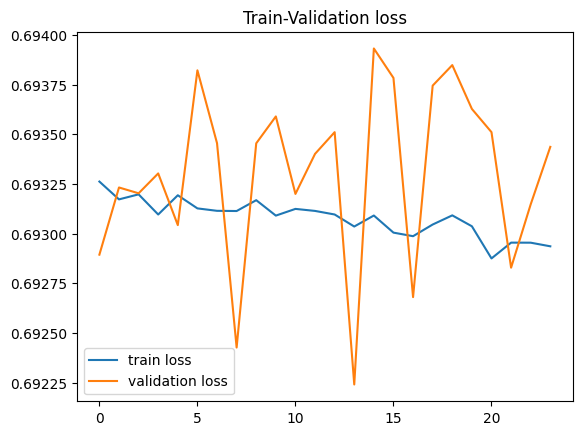

In [24]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_to_v1_1'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [25]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5114795918367347, 'precision': 0.5114795918367347, 'f1': 0.5114795918367347, 'accuracy': 0.5114795918367347}
MALE {'recall': 0.010416666666666666, 'precision': 0.010416666666666666, 'f1': 0.010416666666666666, 'accuracy': 0.010416666666666666}
FEMALE {'recall': 0.9925, 'precision': 0.9925, 'f1': 0.9925, 'accuracy': 0.9925} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.47853535353535354, 'precision': 0.47853535353535354, 'f1': 0.47853535353535354, 'accuracy': 0.47853535353535354}
MALE {'recall': 0.0024330900243309003, 'precision': 0.0024330900243309003, 'f1': 0.0024330900243309003, 'accuracy': 0.0024330900243309003}
FEMALE {'recall': 0.9921259842519685, 'precision': 0.9921259842519685, 'f1': 0.9921259842519685, 'accuracy': 0.9921259842519685} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.48370273794002605, 'precision': 0.48370273794002605, 'f1': 0.48370273794002605, 'accuracy': 0.4837027

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6932433339984575 	 Validation loss: 0.6920059727410138 	 
  1%|          | 574/57400 [00:03<05:16, 179.40it/s]
Epoch 2 	 Training loss: 0.6931785788477921 	 Validation loss: 0.6929642830864858 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:06<05:18, 176.74it/s]
Epoch 3 	 Training loss: 0.6931787001338985 	 Validation loss: 0.6937599444793443 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:10<05:08, 180.28it/s]
Epoch 4 	 Training loss: 0.6931148685437046 	 Validation loss: 0.6928253537517483 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:13<05:06, 179.87it/s]
Epoch 5 	 Training loss: 0.6930772295604599 	 Validation loss: 0.6932950797727553 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [00:17<05:02, 180.15it/s]
Epoch 6 	 Training loss: 0.6931441123061894 	 Validation loss: 0.6938214544522561 	 

5 epoch without improvement
  6%|▌         | 3444/57400 [00:20<05:00, 179.64it/s]
Epoch 7 	 Training los

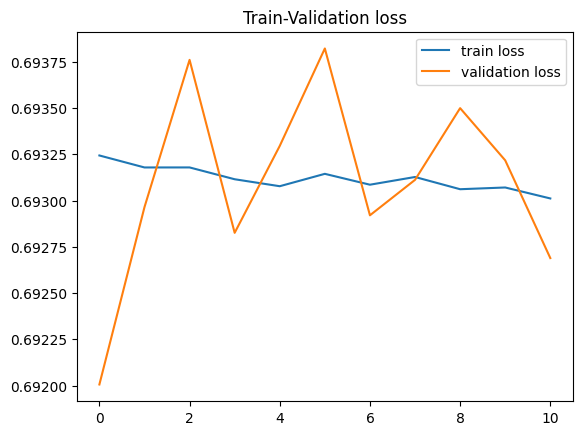

In [26]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_to_v1_2'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [27]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5102040816326531, 'precision': 0.5102040816326531, 'f1': 0.5102040816326531, 'accuracy': 0.5102040816326531}
MALE {'recall': 0.005208333333333333, 'precision': 0.005208333333333333, 'f1': 0.005208333333333333, 'accuracy': 0.005208333333333333}
FEMALE {'recall': 0.995, 'precision': 0.995, 'f1': 0.995, 'accuracy': 0.995} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4810606060606061, 'precision': 0.4810606060606061, 'f1': 0.4810606060606061, 'accuracy': 0.4810606060606061}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.48370273794002605, 'precision': 0.48370273794002605, 'f1': 0.48370273794002605, 'accuracy': 0.48370273794002605}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6932934392827729 	 Validation loss: 0.692597265970909 	 
  1%|          | 574/57400 [00:03<05:23, 175.47it/s]
Epoch 2 	 Training loss: 0.6932644787981119 	 Validation loss: 0.6931569899542857 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:06<05:16, 177.54it/s]
Epoch 3 	 Training loss: 0.693159530075585 	 Validation loss: 0.6924558393025803 	 
  3%|▎         | 1722/57400 [00:10<05:08, 180.24it/s]
Epoch 4 	 Training loss: 0.6931492871108371 	 Validation loss: 0.6925703862966117 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:13<05:12, 176.15it/s]
Epoch 5 	 Training loss: 0.6931585283229575 	 Validation loss: 0.6923654059232291 	 
  5%|▌         | 2870/57400 [00:17<05:02, 180.01it/s]
Epoch 6 	 Training loss: 0.6930700967328474 	 Validation loss: 0.6939303693124803 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [00:20<05:03, 177.62it/s]
Epoch 7 	 Training loss: 0.6930318276433579 	 Validation loss: 0.6942692631382054 

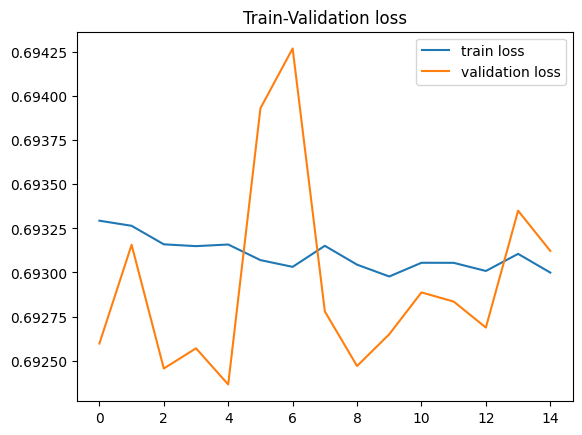

In [28]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_to_v1_3'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [29]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.514030612244898, 'precision': 0.514030612244898, 'f1': 0.514030612244898, 'accuracy': 0.514030612244898}
MALE {'recall': 0.12239583333333333, 'precision': 0.12239583333333333, 'f1': 0.12239583333333333, 'accuracy': 0.12239583333333333}
FEMALE {'recall': 0.89, 'precision': 0.89, 'f1': 0.89, 'accuracy': 0.89} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4595959595959596, 'precision': 0.4595959595959596, 'f1': 0.4595959595959596, 'accuracy': 0.4595959595959596}
MALE {'recall': 0.09245742092457421, 'precision': 0.09245742092457421, 'f1': 0.09245742092457421, 'accuracy': 0.09245742092457421}
FEMALE {'recall': 0.8556430446194225, 'precision': 0.8556430446194225, 'f1': 0.8556430446194225, 'accuracy': 0.8556430446194225} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4980443285528031, 'precision': 0.4980443285528031, 'f1': 0.4980443285528031, 'accuracy': 0.4980443285528031}
MALE {'recall': 0.14

In [30]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.511904761904762, 'precision': 0.511904761904762, 'f1': 0.511904761904762, 'accuracy': 0.511904761904762}
Métricas etiqueta male: {'recall': 0.04600694444444444, 'precision': 0.04600694444444444, 'f1': 0.04600694444444444, 'accuracy': 0.04600694444444444}
Métricas etiqueta female:  {'recall': 0.9591666666666667, 'precision': 0.9591666666666667, 'f1': 0.9591666666666667, 'accuracy': 0.9591666666666667}

 to
Resultado global: {'recall': 0.4730639730639731, 'precision': 0.4730639730639731, 'f1': 0.4730639730639731, 'accuracy': 0.4730639730639731}
Métricas etiqueta male: {'recall': 0.0316301703163017, 'precision': 0.0316301703163017, 'f1': 0.0316301703163017, 'accuracy': 0.0316301703163017}
Métricas etiqueta female:  {'recall': 0.9492563429571304, 'precision': 0.9492563429571304, 'f1': 0.9492563429571304, 'accuracy': 0.9492563429571304}

 as
Resultado global: {'recall': 0.48848326814428505, 'precision': 0.48848326814428505, 'f1': 0

# AS

In [31]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.693268267846689 	 Validation loss: 0.6932693022792622 	 
  1%|          | 574/57400 [00:03<05:19, 177.68it/s]
Epoch 2 	 Training loss: 0.6931485532675886 	 Validation loss: 0.6927291144758968 	 
  2%|▏         | 1148/57400 [00:06<05:17, 177.37it/s]
Epoch 3 	 Training loss: 0.6930568551560312 	 Validation loss: 0.6926225777399742 	 
  3%|▎         | 1722/57400 [00:10<05:15, 176.45it/s]
Epoch 4 	 Training loss: 0.6929829176710043 	 Validation loss: 0.6930082086789406 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:13<05:07, 179.27it/s]
Epoch 5 	 Training loss: 0.6930600102562522 	 Validation loss: 0.6933325397766242 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [00:17<05:05, 178.34it/s]
Epoch 6 	 Training loss: 0.6930598732901783 	 Validation loss: 0.6938090304196891 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [00:20<05:01, 178.89it/s]
Epoch 7 	 Training loss: 0.6930160075945306 	 Validation loss: 0.692689481428114 

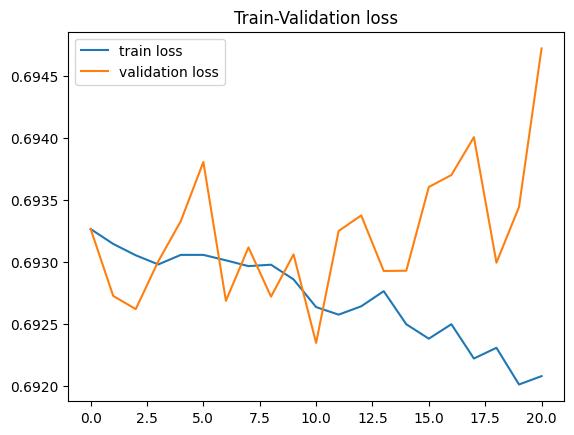

In [32]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_as_v1_1'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [33]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.4923469387755102, 'precision': 0.4923469387755102, 'f1': 0.4923469387755102, 'accuracy': 0.4923469387755102}
MALE {'recall': 0.4348958333333333, 'precision': 0.4348958333333333, 'f1': 0.4348958333333333, 'accuracy': 0.4348958333333333}
FEMALE {'recall': 0.5475, 'precision': 0.5475, 'f1': 0.5475, 'accuracy': 0.5475} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5202020202020202, 'precision': 0.5202020202020202, 'f1': 0.5202020202020202, 'accuracy': 0.5202020202020202}
MALE {'recall': 0.40875912408759124, 'precision': 0.40875912408759124, 'f1': 0.4087591240875913, 'accuracy': 0.40875912408759124}
FEMALE {'recall': 0.6404199475065617, 'precision': 0.6404199475065617, 'f1': 0.6404199475065617, 'accuracy': 0.6404199475065617} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5058670143415906, 'precision': 0.5058670143415906, 'f1': 0.5058670143415906, 'accuracy': 0.5058670143415906}
MALE {'recall

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6932820523034405 	 Validation loss: 0.6928114204083459 	 
  1%|          | 574/57400 [00:03<05:21, 176.85it/s]
Epoch 2 	 Training loss: 0.6931934030629201 	 Validation loss: 0.6931371426178237 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:06<05:21, 174.87it/s]
Epoch 3 	 Training loss: 0.6931312333416025 	 Validation loss: 0.69286757606571 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:10<05:10, 179.04it/s]
Epoch 4 	 Training loss: 0.6930914416338093 	 Validation loss: 0.6938370941048961 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:13<05:11, 176.81it/s]
Epoch 5 	 Training loss: 0.6931090942658614 	 Validation loss: 0.6928680761385773 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [00:17<05:06, 177.90it/s]
Epoch 6 	 Training loss: 0.6929286871014572 	 Validation loss: 0.6939223540031304 	 

5 epoch without improvement
  6%|▌         | 3444/57400 [00:20<05:04, 177.47it/s]
Epoch 7 	 Training loss:

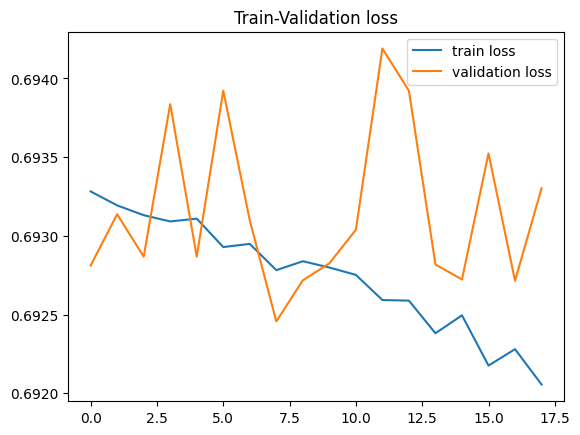

In [34]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_as_v1_2'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [35]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.49107142857142855, 'precision': 0.49107142857142855, 'f1': 0.49107142857142855, 'accuracy': 0.49107142857142855}
MALE {'recall': 0.4973958333333333, 'precision': 0.4973958333333333, 'f1': 0.4973958333333333, 'accuracy': 0.4973958333333333}
FEMALE {'recall': 0.485, 'precision': 0.485, 'f1': 0.485, 'accuracy': 0.485} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5037878787878788, 'precision': 0.5037878787878788, 'f1': 0.5037878787878788, 'accuracy': 0.5037878787878788}
MALE {'recall': 0.5328467153284672, 'precision': 0.5328467153284672, 'f1': 0.5328467153284672, 'accuracy': 0.5328467153284672}
FEMALE {'recall': 0.47244094488188976, 'precision': 0.47244094488188976, 'f1': 0.47244094488188976, 'accuracy': 0.47244094488188976} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5332464146023468, 'precision': 0.5332464146023468, 'f1': 0.5332464146023468, 'accuracy': 0.5332464146023468}
MALE {'recal

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6932488570852977 	 Validation loss: 0.6928994039357719 	 
  1%|          | 574/57400 [00:03<05:21, 176.95it/s]
Epoch 2 	 Training loss: 0.6932126970033612 	 Validation loss: 0.6931009464344736 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:06<05:18, 176.72it/s]
Epoch 3 	 Training loss: 0.6931105150162966 	 Validation loss: 0.6932902386633016 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:10<05:12, 177.96it/s]
Epoch 4 	 Training loss: 0.6931049108297568 	 Validation loss: 0.6928495027251163 	 
  4%|▍         | 2296/57400 [00:13<05:07, 179.09it/s]
Epoch 5 	 Training loss: 0.6930728764484153 	 Validation loss: 0.6934214729373738 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [00:17<05:10, 175.88it/s]
Epoch 6 	 Training loss: 0.6930680653982462 	 Validation loss: 0.6930386868573851 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [00:20<05:11, 173.17it/s]
Epoch 7 	 Training loss: 0.6930413713438586 	 Valid

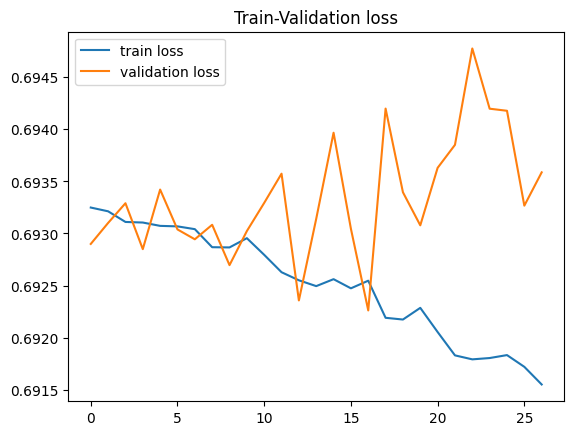

In [36]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_as_v1_3'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [37]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.4885204081632653, 'precision': 0.4885204081632653, 'f1': 0.4885204081632653, 'accuracy': 0.4885204081632653}
MALE {'recall': 0.5989583333333334, 'precision': 0.5989583333333334, 'f1': 0.5989583333333334, 'accuracy': 0.5989583333333334}
FEMALE {'recall': 0.3825, 'precision': 0.3825, 'f1': 0.3825, 'accuracy': 0.3825} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5063131313131313, 'precision': 0.5063131313131313, 'f1': 0.5063131313131313, 'accuracy': 0.5063131313131313}
MALE {'recall': 0.6545012165450121, 'precision': 0.6545012165450121, 'f1': 0.6545012165450121, 'accuracy': 0.6545012165450121}
FEMALE {'recall': 0.3464566929133858, 'precision': 0.3464566929133858, 'f1': 0.3464566929133858, 'accuracy': 0.3464566929133858} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.49674054758800523, 'precision': 0.49674054758800523, 'f1': 0.49674054758800523, 'accuracy': 0.49674054758800523}
MALE {'recal

In [38]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.4906462585034014, 'precision': 0.4906462585034014, 'f1': 0.4906462585034014, 'accuracy': 0.4906462585034014}
Métricas etiqueta male: {'recall': 0.5104166666666666, 'precision': 0.5104166666666666, 'f1': 0.5104166666666666, 'accuracy': 0.5104166666666666}
Métricas etiqueta female:  {'recall': 0.4716666666666667, 'precision': 0.4716666666666667, 'f1': 0.4716666666666667, 'accuracy': 0.4716666666666667}

 to
Resultado global: {'recall': 0.51010101010101, 'precision': 0.51010101010101, 'f1': 0.51010101010101, 'accuracy': 0.51010101010101}
Métricas etiqueta male: {'recall': 0.5320356853203568, 'precision': 0.5320356853203568, 'f1': 0.5320356853203568, 'accuracy': 0.5320356853203568}
Métricas etiqueta female:  {'recall': 0.48643919510061245, 'precision': 0.48643919510061245, 'f1': 0.48643919510061245, 'accuracy': 0.48643919510061245}

 as
Resultado global: {'recall': 0.5119513255106476, 'precision': 0.5119513255106476, 'f1': 0.51195

# Pruebas hiperparámetros 2

In [39]:
emb_dim = 20
vocab_size = len(word_to_index)
# num_labels = 2
lstm_hidden_dim = 64

## ABOUT

In [40]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6808026241923874 	 Validation loss: 0.6827180375487117 	 
  1%|          | 574/57400 [00:02<03:23, 279.58it/s]
Epoch 2 	 Training loss: 0.678289958824264 	 Validation loss: 0.6779413132344262 	 
  2%|▏         | 1148/57400 [00:04<03:28, 270.01it/s]
Epoch 3 	 Training loss: 0.6688200162678231 	 Validation loss: 0.6640153385825076 	 
  3%|▎         | 1722/57400 [00:06<03:29, 265.47it/s]
Epoch 4 	 Training loss: 0.6583787933874629 	 Validation loss: 0.6560039409136368 	 
  4%|▍         | 2296/57400 [00:08<03:19, 276.51it/s]
Epoch 5 	 Training loss: 0.6509186471796202 	 Validation loss: 0.6491353249145766 	 
  5%|▌         | 2870/57400 [00:11<03:19, 273.63it/s]
Epoch 6 	 Training loss: 0.6438054384254828 	 Validation loss: 0.6436474868806742 	 
  6%|▌         | 3444/57400 [00:13<03:15, 276.16it/s]
Epoch 7 	 Training loss: 0.6373238346510233 	 Validation loss: 0.635949087344994 	 
  7%|▋         | 4018/57400 [00:15<03:13, 276.52it/s]
Epoch 8 	 Training loss: 0.630

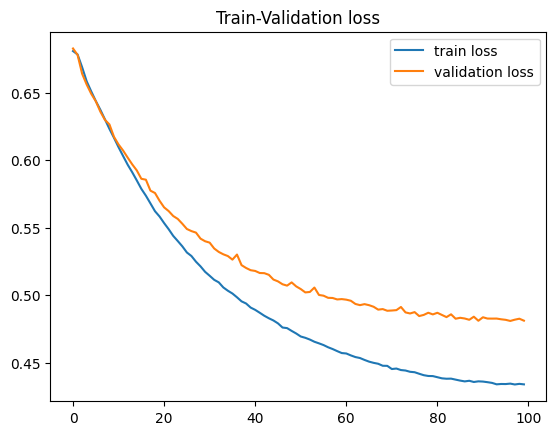

In [41]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_about_v2_1'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [42]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.673469387755102, 'precision': 0.673469387755102, 'f1': 0.673469387755102, 'accuracy': 0.673469387755102}
MALE {'recall': 0.8619791666666666, 'precision': 0.8619791666666666, 'f1': 0.8619791666666666, 'accuracy': 0.8619791666666666}
FEMALE {'recall': 0.4925, 'precision': 0.4925, 'f1': 0.4925, 'accuracy': 0.4925} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5265151515151515, 'precision': 0.5265151515151515, 'f1': 0.5265151515151515, 'accuracy': 0.5265151515151515}
MALE {'recall': 0.708029197080292, 'precision': 0.708029197080292, 'f1': 0.708029197080292, 'accuracy': 0.708029197080292}
FEMALE {'recall': 0.33070866141732286, 'precision': 0.33070866141732286, 'f1': 0.33070866141732286, 'accuracy': 0.33070866141732286} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5710560625814863, 'precision': 0.5710560625814863, 'f1': 0.5710560625814863, 'accuracy': 0.5710560625814863}
MALE {'recall': 0.75

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6817519352203463 	 Validation loss: 0.6833221983101408 	 
  1%|          | 574/57400 [00:02<03:25, 275.94it/s]
Epoch 2 	 Training loss: 0.6779322139269799 	 Validation loss: 0.6792673216027728 	 
  2%|▏         | 1148/57400 [00:04<03:23, 276.34it/s]
Epoch 3 	 Training loss: 0.6660197142524586 	 Validation loss: 0.6702068235914586 	 
  3%|▎         | 1722/57400 [00:06<03:20, 277.50it/s]
Epoch 4 	 Training loss: 0.6579035342985745 	 Validation loss: 0.6638421143515635 	 
  4%|▍         | 2296/57400 [00:08<03:20, 274.45it/s]
Epoch 5 	 Training loss: 0.651374291252176 	 Validation loss: 0.6584741028688722 	 
  5%|▌         | 2870/57400 [00:11<03:17, 276.61it/s]
Epoch 6 	 Training loss: 0.644787946229197 	 Validation loss: 0.6528483800968882 	 
  6%|▌         | 3444/57400 [00:13<03:15, 275.33it/s]
Epoch 7 	 Training loss: 0.6384170163383882 	 Validation loss: 0.6462108331211542 	 
  7%|▋         | 4018/57400 [00:15<03:16, 271.35it/s]
Epoch 8 	 Training loss: 0.631

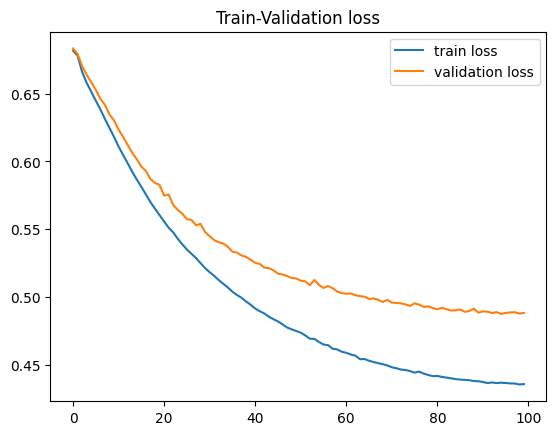

In [43]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_about_v2_2'

optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [44]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.6607142857142857, 'precision': 0.6607142857142857, 'f1': 0.6607142857142857, 'accuracy': 0.6607142857142857}
MALE {'recall': 0.4635416666666667, 'precision': 0.4635416666666667, 'f1': 0.4635416666666667, 'accuracy': 0.4635416666666667}
FEMALE {'recall': 0.85, 'precision': 0.85, 'f1': 0.85, 'accuracy': 0.85} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5050505050505051, 'precision': 0.5050505050505051, 'f1': 0.5050505050505051, 'accuracy': 0.5050505050505051}
MALE {'recall': 0.25060827250608275, 'precision': 0.25060827250608275, 'f1': 0.25060827250608275, 'accuracy': 0.25060827250608275}
FEMALE {'recall': 0.7795275590551181, 'precision': 0.7795275590551181, 'f1': 0.7795275590551181, 'accuracy': 0.7795275590551181} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5684485006518905, 'precision': 0.5684485006518905, 'f1': 0.5684485006518905, 'accuracy': 0.5684485006518905}
MALE {'recall': 0.32

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6810944522714781 	 Validation loss: 0.682432407039707 	 
  1%|          | 574/57400 [00:02<03:26, 275.72it/s]
Epoch 2 	 Training loss: 0.6757593180867437 	 Validation loss: 0.6703928032163846 	 
  2%|▏         | 1148/57400 [00:04<03:26, 272.63it/s]
Epoch 3 	 Training loss: 0.6592464808387624 	 Validation loss: 0.6598693556704763 	 
  3%|▎         | 1722/57400 [00:06<03:20, 277.31it/s]
Epoch 4 	 Training loss: 0.6512586933395174 	 Validation loss: 0.6546441690396454 	 
  4%|▍         | 2296/57400 [00:08<03:20, 274.92it/s]
Epoch 5 	 Training loss: 0.644227728922608 	 Validation loss: 0.6473711981611737 	 
  5%|▌         | 2870/57400 [00:11<03:15, 278.54it/s]
Epoch 6 	 Training loss: 0.6376695805310372 	 Validation loss: 0.6403289265551809 	 
  6%|▌         | 3444/57400 [00:13<03:14, 277.67it/s]
Epoch 7 	 Training loss: 0.6308304606206742 	 Validation loss: 0.634401238570779 	 
  7%|▋         | 4018/57400 [00:15<03:13, 276.44it/s]
Epoch 8 	 Training loss: 0.6242

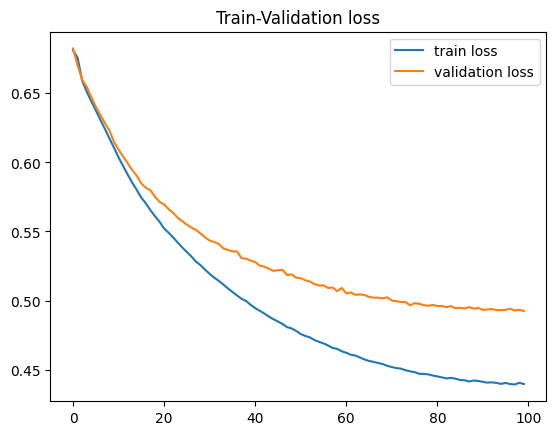

In [45]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_about_v2_3'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [46]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.6811224489795918, 'precision': 0.6811224489795918, 'f1': 0.6811224489795918, 'accuracy': 0.6811224489795918}
MALE {'recall': 0.5598958333333334, 'precision': 0.5598958333333334, 'f1': 0.5598958333333334, 'accuracy': 0.5598958333333334}
FEMALE {'recall': 0.7975, 'precision': 0.7975, 'f1': 0.7975, 'accuracy': 0.7975} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5050505050505051, 'precision': 0.5050505050505051, 'f1': 0.5050505050505051, 'accuracy': 0.5050505050505051}
MALE {'recall': 0.3381995133819951, 'precision': 0.3381995133819951, 'f1': 0.3381995133819951, 'accuracy': 0.3381995133819951}
FEMALE {'recall': 0.6850393700787402, 'precision': 0.6850393700787402, 'f1': 0.6850393700787402, 'accuracy': 0.6850393700787402} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5619295958279009, 'precision': 0.5619295958279009, 'f1': 0.5619295958279009, 'accuracy': 0.5619295958279009}
MALE {'recall': 

In [47]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.6717687074829932, 'precision': 0.6717687074829932, 'f1': 0.6717687074829932, 'accuracy': 0.6717687074829932}
Métricas etiqueta male: {'recall': 0.6284722222222222, 'precision': 0.6284722222222222, 'f1': 0.6284722222222222, 'accuracy': 0.6284722222222222}
Métricas etiqueta female:  {'recall': 0.7133333333333334, 'precision': 0.7133333333333334, 'f1': 0.7133333333333334, 'accuracy': 0.7133333333333334}

 to
Resultado global: {'recall': 0.5122053872053872, 'precision': 0.5122053872053872, 'f1': 0.5122053872053872, 'accuracy': 0.5122053872053872}
Métricas etiqueta male: {'recall': 0.43227899432278993, 'precision': 0.43227899432278993, 'f1': 0.43227899432278993, 'accuracy': 0.43227899432278993}
Métricas etiqueta female:  {'recall': 0.5984251968503937, 'precision': 0.5984251968503937, 'f1': 0.5984251968503937, 'accuracy': 0.5984251968503937}

 as
Resultado global: {'recall': 0.5671447196870926, 'precision': 0.5671447196870926, 'f1':

## TO

In [48]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6932114969147207 	 Validation loss: 0.6926561654624293 	 
  1%|          | 574/57400 [00:03<04:36, 205.73it/s]
Epoch 2 	 Training loss: 0.6931913681977302 	 Validation loss: 0.6930353510177741 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:05<04:32, 206.21it/s]
Epoch 3 	 Training loss: 0.6932121319014851 	 Validation loss: 0.6934771113476511 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:08<04:31, 205.31it/s]
Epoch 4 	 Training loss: 0.6932004295575078 	 Validation loss: 0.6931069129604405 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:11<04:29, 204.15it/s]
Epoch 5 	 Training loss: 0.693162626401888 	 Validation loss: 0.6925502843775991 	 
  5%|▌         | 2870/57400 [00:14<04:23, 206.96it/s]
Epoch 6 	 Training loss: 0.693077272239047 	 Validation loss: 0.6930869686401496 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [00:17<04:24, 204.19it/s]
Epoch 7 	 Training loss: 0.6930993755935376 	 Validat

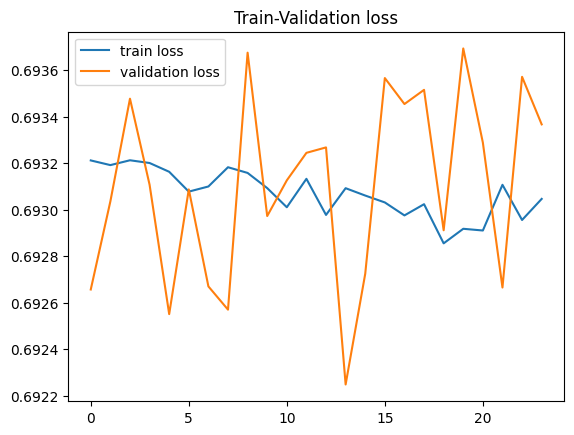

In [49]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_to_v2_1'

optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [50]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load('m1_rrnn_simple_to_v2_1'))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5089285714285714, 'precision': 0.5089285714285714, 'f1': 0.5089285714285714, 'accuracy': 0.5089285714285714}
MALE {'recall': 0.028645833333333332, 'precision': 0.028645833333333332, 'f1': 0.028645833333333332, 'accuracy': 0.028645833333333332}
FEMALE {'recall': 0.97, 'precision': 0.97, 'f1': 0.97, 'accuracy': 0.97} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.476010101010101, 'precision': 0.476010101010101, 'f1': 0.476010101010101, 'accuracy': 0.476010101010101}
MALE {'recall': 0.009732360097323601, 'precision': 0.009732360097323601, 'f1': 0.009732360097323601, 'accuracy': 0.009732360097323601}
FEMALE {'recall': 0.979002624671916, 'precision': 0.979002624671916, 'f1': 0.979002624671916, 'accuracy': 0.979002624671916} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.47979139504563234, 'precision': 0.47979139504563234, 'f1': 0.47979139504563234, 'accuracy': 0.47979139504563234}
MALE {'recal

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6933122125652194 	 Validation loss: 0.6931218787775202 	 
  1%|          | 574/57400 [00:02<04:30, 209.75it/s]
Epoch 2 	 Training loss: 0.6932264105368159 	 Validation loss: 0.6930370229785725 	 
  2%|▏         | 1148/57400 [00:05<04:26, 211.14it/s]
Epoch 3 	 Training loss: 0.6931283567425266 	 Validation loss: 0.6922354283979384 	 
  3%|▎         | 1722/57400 [00:08<04:27, 207.89it/s]
Epoch 4 	 Training loss: 0.6931536706482492 	 Validation loss: 0.6934745635016489 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:11<04:24, 208.39it/s]
Epoch 5 	 Training loss: 0.6931372951547443 	 Validation loss: 0.6929957482774379 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [00:14<04:17, 211.68it/s]
Epoch 6 	 Training loss: 0.6931368466661367 	 Validation loss: 0.6941713559425483 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [00:17<04:16, 210.46it/s]
Epoch 7 	 Training loss: 0.6931228765419551 	 Validation loss: 0.693107562550043

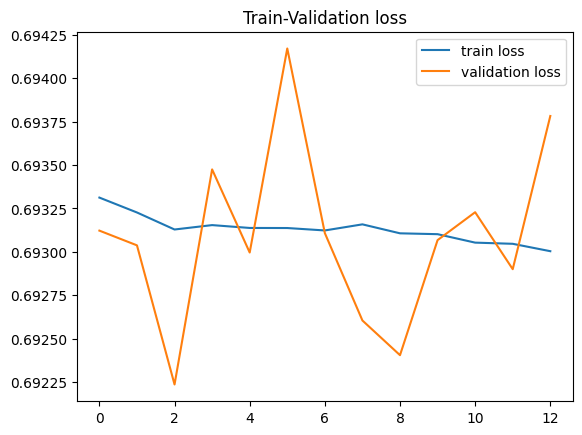

In [51]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_to_v2_2'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [52]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.48086734693877553, 'precision': 0.48086734693877553, 'f1': 0.48086734693877553, 'accuracy': 0.48086734693877553}
MALE {'recall': 0.5130208333333334, 'precision': 0.5130208333333334, 'f1': 0.5130208333333334, 'accuracy': 0.5130208333333334}
FEMALE {'recall': 0.45, 'precision': 0.45, 'f1': 0.45, 'accuracy': 0.45} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5366161616161617, 'precision': 0.5366161616161617, 'f1': 0.5366161616161617, 'accuracy': 0.5366161616161617}
MALE {'recall': 0.5815085158150851, 'precision': 0.5815085158150851, 'f1': 0.5815085158150851, 'accuracy': 0.5815085158150851}
FEMALE {'recall': 0.4881889763779528, 'precision': 0.4881889763779528, 'f1': 0.4881889763779528, 'accuracy': 0.4881889763779528} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4863102998696219, 'precision': 0.4863102998696219, 'f1': 0.4863102998696219, 'accuracy': 0.4863102998696219}
MALE {'recall': 0.51

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6932440813410158 	 Validation loss: 0.6930486367920697 	 
  1%|          | 574/57400 [00:03<04:32, 208.80it/s]
Epoch 2 	 Training loss: 0.6931204828028065 	 Validation loss: 0.6917888411020828 	 
  2%|▏         | 1148/57400 [00:05<04:32, 206.08it/s]
Epoch 3 	 Training loss: 0.693141960204686 	 Validation loss: 0.6928644028760619 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:08<04:27, 208.44it/s]
Epoch 4 	 Training loss: 0.6930819684412421 	 Validation loss: 0.6931648587776442 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [00:11<04:22, 209.89it/s]
Epoch 5 	 Training loss: 0.6931649073698795 	 Validation loss: 0.692497441324137 	 

3 epoch without improvement
  5%|▌         | 2870/57400 [00:14<04:21, 208.40it/s]
Epoch 6 	 Training loss: 0.6931445096012607 	 Validation loss: 0.6925041524030394 	 

4 epoch without improvement
  6%|▌         | 3444/57400 [00:17<04:17, 209.44it/s]
Epoch 7 	 Training loss: 0.6930861309014962 	 Validat

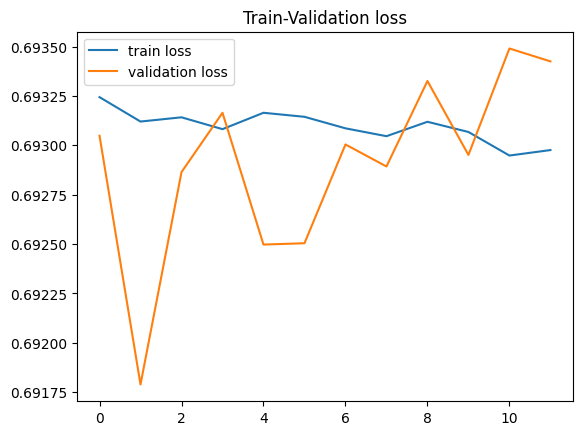

In [53]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_to_v2_3'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [54]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5089285714285714, 'precision': 0.5089285714285714, 'f1': 0.5089285714285714, 'accuracy': 0.5089285714285714}
MALE {'recall': 0.013020833333333334, 'precision': 0.013020833333333334, 'f1': 0.013020833333333334, 'accuracy': 0.013020833333333334}
FEMALE {'recall': 0.985, 'precision': 0.985, 'f1': 0.985, 'accuracy': 0.985} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.48358585858585856, 'precision': 0.48358585858585856, 'f1': 0.48358585858585856, 'accuracy': 0.48358585858585856}
MALE {'recall': 0.012165450121654502, 'precision': 0.012165450121654502, 'f1': 0.012165450121654502, 'accuracy': 0.012165450121654502}
FEMALE {'recall': 0.9921259842519685, 'precision': 0.9921259842519685, 'f1': 0.9921259842519685, 'accuracy': 0.9921259842519685} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4863102998696219, 'precision': 0.4863102998696219, 'f1': 0.4863102998696219, 'accuracy': 0.4863102998696219}


In [55]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.4995748299319728, 'precision': 0.4995748299319728, 'f1': 0.4995748299319728, 'accuracy': 0.4995748299319728}
Métricas etiqueta male: {'recall': 0.18489583333333334, 'precision': 0.18489583333333334, 'f1': 0.18489583333333334, 'accuracy': 0.18489583333333334}
Métricas etiqueta female:  {'recall': 0.8016666666666666, 'precision': 0.8016666666666666, 'f1': 0.8016666666666666, 'accuracy': 0.8016666666666666}

 to
Resultado global: {'recall': 0.49873737373737376, 'precision': 0.49873737373737376, 'f1': 0.49873737373737376, 'accuracy': 0.49873737373737376}
Métricas etiqueta male: {'recall': 0.20113544201135442, 'precision': 0.20113544201135442, 'f1': 0.20113544201135442, 'accuracy': 0.20113544201135442}
Métricas etiqueta female:  {'recall': 0.8197725284339458, 'precision': 0.8197725284339458, 'f1': 0.8197725284339458, 'accuracy': 0.8197725284339458}

 as
Resultado global: {'recall': 0.4841373315949587, 'precision': 0.484137331594958

## AS

In [56]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6932826871863641 	 Validation loss: 0.6927282830416146 	 
  1%|          | 574/57400 [00:02<04:31, 208.98it/s]
Epoch 2 	 Training loss: 0.6930907102827412 	 Validation loss: 0.6925559266138885 	 
  2%|▏         | 1148/57400 [00:05<04:28, 209.24it/s]
Epoch 3 	 Training loss: 0.6931229591992674 	 Validation loss: 0.6930166048518682 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:08<04:27, 208.36it/s]
Epoch 4 	 Training loss: 0.6931227508945332 	 Validation loss: 0.692546131247181 	 
  4%|▍         | 2296/57400 [00:11<04:26, 207.02it/s]
Epoch 5 	 Training loss: 0.6930371742007624 	 Validation loss: 0.6931252479553223 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [00:14<04:22, 207.89it/s]
Epoch 6 	 Training loss: 0.6930470267239348 	 Validation loss: 0.6936113379769406 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [00:17<04:22, 205.58it/s]
Epoch 7 	 Training loss: 0.693055421737013 	 Validation loss: 0.6929077950574584 

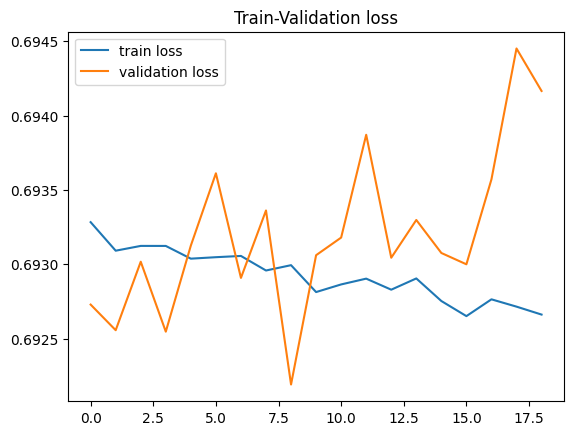

In [57]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_as_v2_1'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [58]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.4744897959183674, 'precision': 0.4744897959183674, 'f1': 0.4744897959183674, 'accuracy': 0.4744897959183674}
MALE {'recall': 0.375, 'precision': 0.375, 'f1': 0.375, 'accuracy': 0.375}
FEMALE {'recall': 0.57, 'precision': 0.57, 'f1': 0.57, 'accuracy': 0.57} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5075757575757576, 'precision': 0.5075757575757576, 'f1': 0.5075757575757576, 'accuracy': 0.5075757575757576}
MALE {'recall': 0.4209245742092457, 'precision': 0.4209245742092457, 'f1': 0.4209245742092457, 'accuracy': 0.4209245742092457}
FEMALE {'recall': 0.6010498687664042, 'precision': 0.6010498687664042, 'f1': 0.6010498687664042, 'accuracy': 0.6010498687664042} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.516297262059974, 'precision': 0.516297262059974, 'f1': 0.516297262059974, 'accuracy': 0.516297262059974}
MALE {'recall': 0.3813131313131313, 'precision': 0.3813131313131313, 'f1': 0.381

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.693321540484445 	 Validation loss: 0.6926483037108082 	 
  1%|          | 574/57400 [00:02<04:33, 208.02it/s]
Epoch 2 	 Training loss: 0.6931188687007186 	 Validation loss: 0.692431101354502 	 
  2%|▏         | 1148/57400 [00:05<04:26, 210.78it/s]
Epoch 3 	 Training loss: 0.6930552952588643 	 Validation loss: 0.6928946436461756 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:08<04:22, 212.14it/s]
Epoch 4 	 Training loss: 0.6930193985173095 	 Validation loss: 0.6922653923600407 	 
  4%|▍         | 2296/57400 [00:11<04:26, 207.14it/s]
Epoch 5 	 Training loss: 0.6931250668568893 	 Validation loss: 0.6931913636498532 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [00:14<04:24, 205.93it/s]
Epoch 6 	 Training loss: 0.6931292535120602 	 Validation loss: 0.6925445067680488 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [00:17<04:19, 208.21it/s]
Epoch 7 	 Training loss: 0.6930947456418014 	 Validation loss: 0.6930219753313873 

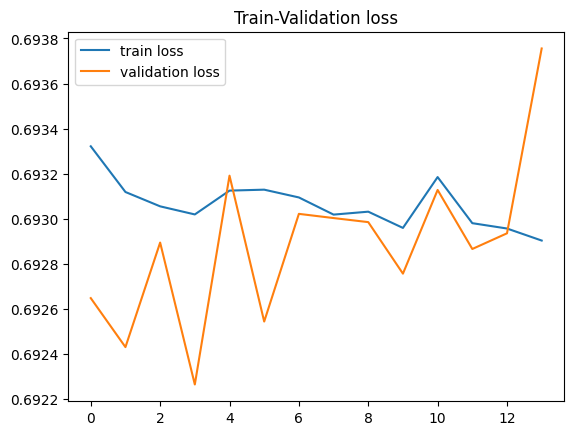

In [59]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_as_v2_2'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [60]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5063775510204082, 'precision': 0.5063775510204082, 'f1': 0.5063775510204082, 'accuracy': 0.5063775510204082}
MALE {'recall': 0.11197916666666667, 'precision': 0.11197916666666667, 'f1': 0.11197916666666667, 'accuracy': 0.11197916666666667}
FEMALE {'recall': 0.885, 'precision': 0.885, 'f1': 0.885, 'accuracy': 0.885} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.48737373737373735, 'precision': 0.48737373737373735, 'f1': 0.48737373737373735, 'accuracy': 0.48737373737373735}
MALE {'recall': 0.07542579075425791, 'precision': 0.07542579075425791, 'f1': 0.07542579075425791, 'accuracy': 0.07542579075425791}
FEMALE {'recall': 0.931758530183727, 'precision': 0.931758530183727, 'f1': 0.931758530183727, 'accuracy': 0.931758530183727} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4941329856584094, 'precision': 0.4941329856584094, 'f1': 0.4941329856584094, 'accuracy': 0.4941329856584094}
MALE {'recal

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6932403818032468 	 Validation loss: 0.6929975737959652 	 
  1%|          | 574/57400 [00:02<04:30, 210.00it/s]
Epoch 2 	 Training loss: 0.693243213439237 	 Validation loss: 0.6925315089144949 	 
  2%|▏         | 1148/57400 [00:05<04:28, 209.87it/s]
Epoch 3 	 Training loss: 0.693164612461881 	 Validation loss: 0.6930356924816713 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:08<04:28, 207.66it/s]
Epoch 4 	 Training loss: 0.6931751005948629 	 Validation loss: 0.6925667180853375 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [00:11<04:22, 209.69it/s]
Epoch 5 	 Training loss: 0.6930253244027859 	 Validation loss: 0.6933105345499717 	 

3 epoch without improvement
  5%|▌         | 2870/57400 [00:14<04:20, 209.03it/s]
Epoch 6 	 Training loss: 0.6930593068383712 	 Validation loss: 0.6928222159207877 	 

4 epoch without improvement
  6%|▌         | 3444/57400 [00:17<04:15, 211.39it/s]
Epoch 7 	 Training loss: 0.6931336087009218 	 Validat

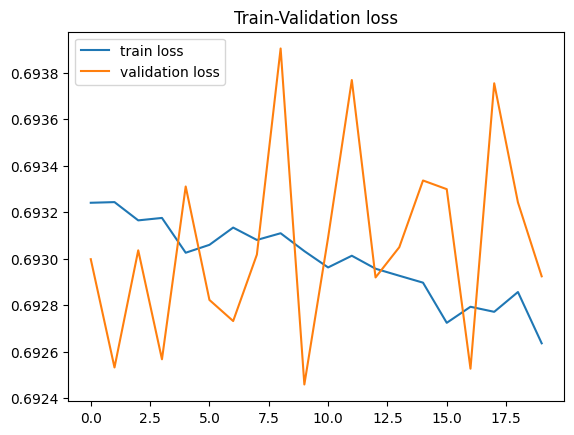

In [61]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_as_v2_3'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [62]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5, 'precision': 0.5, 'f1': 0.5, 'accuracy': 0.5}
MALE {'recall': 0.5416666666666666, 'precision': 0.5416666666666666, 'f1': 0.5416666666666666, 'accuracy': 0.5416666666666666}
FEMALE {'recall': 0.46, 'precision': 0.46, 'f1': 0.46, 'accuracy': 0.46} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5012626262626263, 'precision': 0.5012626262626263, 'f1': 0.5012626262626263, 'accuracy': 0.5012626262626263}
MALE {'recall': 0.5425790754257908, 'precision': 0.5425790754257908, 'f1': 0.5425790754257908, 'accuracy': 0.5425790754257908}
FEMALE {'recall': 0.4566929133858268, 'precision': 0.4566929133858268, 'f1': 0.4566929133858268, 'accuracy': 0.4566929133858268} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5084745762711864, 'precision': 0.5084745762711864, 'f1': 0.5084745762711864, 'accuracy': 0.5084745762711864}
MALE {'recall': 0.5252525252525253, 'precision': 0.5252525252525253, 'f1': 0.5252525

In [63]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.49362244897959184, 'precision': 0.49362244897959184, 'f1': 0.49362244897959184, 'accuracy': 0.49362244897959184}
Métricas etiqueta male: {'recall': 0.3428819444444444, 'precision': 0.3428819444444444, 'f1': 0.3428819444444444, 'accuracy': 0.3428819444444444}
Métricas etiqueta female:  {'recall': 0.6383333333333333, 'precision': 0.6383333333333333, 'f1': 0.6383333333333333, 'accuracy': 0.6383333333333333}

 to
Resultado global: {'recall': 0.49873737373737376, 'precision': 0.49873737373737376, 'f1': 0.49873737373737376, 'accuracy': 0.49873737373737376}
Métricas etiqueta male: {'recall': 0.34630981346309814, 'precision': 0.34630981346309814, 'f1': 0.34630981346309814, 'accuracy': 0.34630981346309814}
Métricas etiqueta female:  {'recall': 0.663167104111986, 'precision': 0.663167104111986, 'f1': 0.663167104111986, 'accuracy': 0.663167104111986}

 as
Resultado global: {'recall': 0.5063016079965232, 'precision': 0.5063016079965232, '